In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [5]:
raw_data = yf.download(tickers='AAPL', period='5y')
df = raw_data.copy()

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-22,29.087500,29.127501,28.910000,29.072500,27.365416,104343600
2016-12-23,28.897499,29.129999,28.897499,29.129999,27.419540,56998000
2016-12-27,29.129999,29.450001,29.122499,29.315001,27.593679,73187600
2016-12-28,29.379999,29.504999,29.049999,29.190001,27.476019,83623600
2016-12-29,29.112499,29.277500,29.100000,29.182501,27.468962,60158000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-12-22 to 2021-12-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [10]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df = df.asfreq('B')
df = df.fillna(method='ffill')

In [11]:
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]

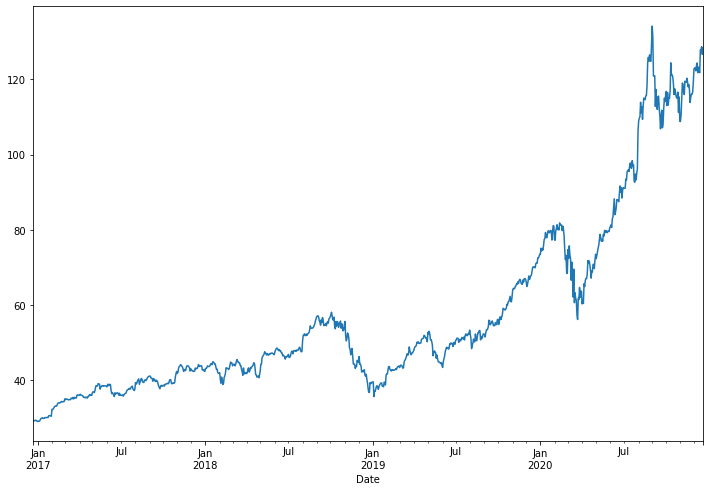

In [13]:
train.Close.plot(figsize=(12, 8))
plt.show()

In [14]:
train.head()

,Close
Date,
2016-12-22,29.072500
2016-12-23,29.129999
2016-12-26,29.129999
2016-12-27,29.315001
2016-12-28,29.190001


In [15]:
from statsmodels.tsa.stattools import adfuller
adfuller(train.Close)

(1.2422193499602951,
 0.9962649843061823,
 9,
 1033,
 {'1%': -3.4366961996098264,
  '5%': -2.8643419712141074,
  '10%': -2.5682618869934934},
 3568.0799869246666)

In [16]:
train['Diff'] = train.Close.diff(1)
train

,Close,Diff
Date,,
2016-12-22,29.072500,NaN
2016-12-23,29.129999,0.057499
2016-12-26,29.129999,0.000000
2016-12-27,29.315001,0.185001
2016-12-28,29.190001,-0.125000
...,...,...
2020-12-15,127.879997,6.099998
2020-12-16,127.809998,-0.070000
2020-12-17,128.699997,0.889999


In [17]:
adfuller(train['Diff'][1:])

(-10.30721448657162,
 3.255150053321967e-18,
 8,
 1033,
 {'1%': -3.4366961996098264,
  '5%': -2.8643419712141074,
  '10%': -2.5682618869934934},
 3565.1378259504713)

In [19]:
import statsmodels.graphics.tsaplots as sgt

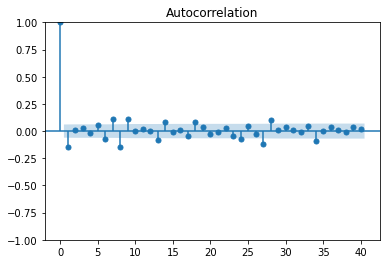

In [20]:
#Plotting the difference between consecutive values
sgt.plot_acf(train.Diff[1:], lags=40)
plt.show()

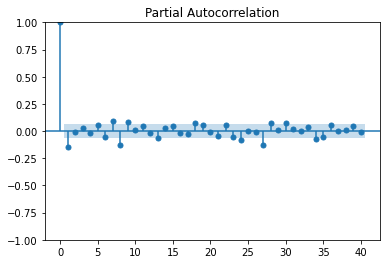

In [21]:
sgt.plot_pacf(train.Diff[1:], lags=40)
plt.show()

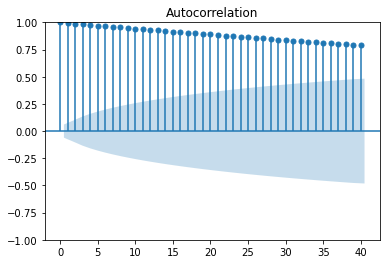

In [25]:
#Plotting the original values
sgt.plot_acf(train.Close, lags=40)
plt.show()

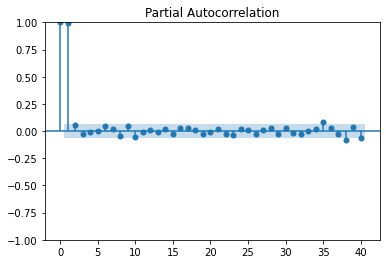

In [26]:
sgt.plot_pacf(train.Close, lags=40)
plt.show()

In [22]:
from pmdarima.arima import auto_arima

In [27]:
model_auto = auto_arima(train.Close, m=5, p=8, q=8)

In [24]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1042
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -1806.046
Date:                Wed, 22 Dec 2021   AIC                           3626.092
Time:                        12:53:25   BIC                           3660.735
Sample:                             0   HQIC                          3639.232
                               - 1042                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3398      0.136      2.504      0.012       0.074       0.606
ar.L1         -1.7370      0.041    -42.725      0.000      -1.817      -1.657
ar.L2         -0.8351      0.037    -22.857      0.000      -0.907      -0.763
ma.L1          1.6211      0.044     36.896      0.000       1.535       1.707
ma.L2          0.6266      0.045     14.068      0.000       0.539       0.714
ma.L3         -0.0681      0.022     -3.055      0.002      -0.112      -0.024
sigma2         1.8745      0.034     55.513      0.000       1.808       1.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6456.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              18.55   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model_ar_2_ma_3 = ARIMA(train.Close, order=(2, 0, 3))
result_ar_2_ma_3 = model_ar_2_ma_3.fit()
result_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1043
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1823.369
Date:                Wed, 22 Dec 2021   AIC                           3660.738
Time:                        12:58:28   BIC                           3695.387
Sample:                    12-22-2016   HQIC                          3673.880
                         - 12-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.5466    127.542      0.451      0.652    -192.432     307.525
ar.L1          0.2091      0.047      4.445      0.000       0.117       0.301
ar.L2          0.7903      0.047     16.867      0.000       0.698       0.882
ma.L1          0.6674      0.049     13.729      0.000       0.572       0.763
ma.L2         -0.1046      0.022     -4.698      0.000      -0.148      -0.061
ma.L3          0.0716      0.016      4.602      0.000       0.041       0.102
sigma2         1.9187      0.034     55.682      0.000       1.851       1.986
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              6297.34
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              19.02   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
test['Diff'] = test.Close.diff(1)

In [30]:
test.index[0]

Timestamp('2020-12-22 00:00:00', freq='B')

In [31]:
test.index[-1]

Timestamp('2021-12-21 00:00:00', freq='B')

In [32]:
predict_ar_2_ma_3 = result_ar_2_ma_3.predict(start=test.index[0], end=test.index[-1])
predict_ar_2_ma_3

2020-12-22    128.276463
2020-12-23    127.873066
2020-12-24    128.258254
2020-12-25    127.909620
2020-12-28    128.141160
                 ...    
2021-12-15    122.090283
2021-12-16    122.067746
2021-12-17    122.045217
2021-12-20    122.022696
2021-12-21    122.000182
Freq: B, Name: predicted_mean, Length: 261, dtype: float64

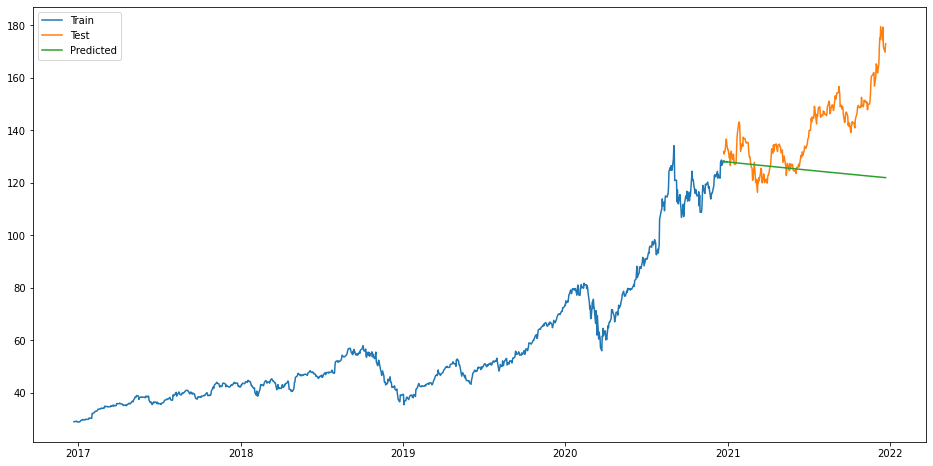

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train.Close, label='Train')
ax.plot(test.Close, label='Test')
ax.plot(predict_ar_2_ma_3, label='Predicted')
plt.legend()
plt.show()

***Prediction on returns***

In [35]:
df['returns'] = df.Close.pct_change(1)
df.head()

,Close,returns
Date,,
2016-12-22,29.072500,NaN
2016-12-23,29.129999,0.001978
2016-12-26,29.129999,0.000000
2016-12-27,29.315001,0.006351
2016-12-28,29.190001,-0.004264


In [36]:
size = int(len(df) * 0.8)
df_train, df_test = df[0:size], df[size:len(df)]

In [37]:
adfuller(df_train.returns[1:])

(-10.188029356298603,
 6.4312116804734215e-18,
 8,
 1033,
 {'1%': -3.4366961996098264,
  '5%': -2.8643419712141074,
  '10%': -2.5682618869934934},
 -5163.945067986533)

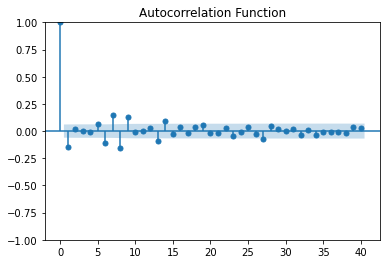

In [38]:
sgt.plot_acf(df_train.returns[1:], lags=40)
plt.title('Autocorrelation Function')
plt.show()

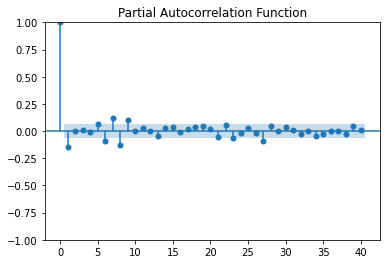

In [39]:
sgt.plot_pacf(df_train.returns[1:], lags=40)
plt.title('Partial Autocorrelation Function')
plt.show()

In [40]:
model_auto_returns = auto_arima(df_train.returns[1:], m=5, p=8, q=8)
model_auto_returns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1042
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 5)   Log Likelihood                2633.871
Date:                           Wed, 22 Dec 2021   AIC                          -5259.741
Time:                                   13:03:14   BIC                          -5239.946
Sample:                                        0   HQIC                         -5252.233
                                          - 1042                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      2.885      0.004       0.001       0.003
ar.L1         -0.1366      0.018     -7.601      0.000      -0.172      -0.101
ar.S.L5        0.0547      0.019      2.811      0.005       0.017       0.093
sigma2         0.0004   8.17e-06     45.667      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1891.56
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.97   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [44]:
model_sar_1_ma_0 = ARIMA(df_train.returns[1:], order=(1, 0, 0), seasonal_order=(1, 0, 0, 5))
result_sar_1_ma_0 = model_sar_1_ma_0.fit()
result_sar_1_ma_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         returns   No. Observations:                 1042
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 5)   Log Likelihood                2633.727
Date:                         Wed, 22 Dec 2021   AIC                          -5259.455
Time:                                 13:07:00   BIC                          -5239.659
Sample:                             12-23-2016   HQIC                         -5251.946
                                  - 12-21-2020                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.833      0.005       0.000       0.003
ar.L1         -0.1424      0.018     -7.904      0.000      -0.178      -0.107
ar.S.L5        0.0695      0.019      3.577      0.000       0.031       0.108
sigma2         0.0004   8.16e-06     45.732      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1874.72
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               3.95   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
df_pred_sar_1_i_ma_0 = result_sar_1_ma_0.predict(start=test.index[0], end=test.index[-1])

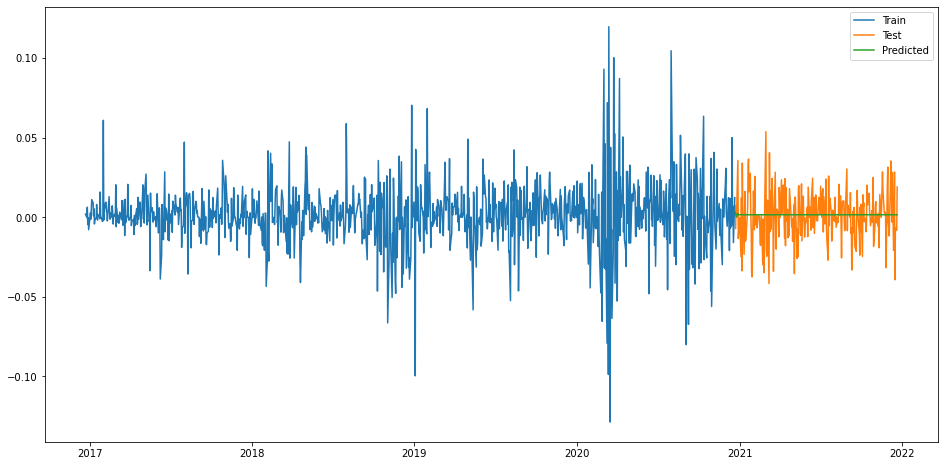

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_train.returns[1:], label='Train')
ax.plot(df_test.returns[1:], label='Test')
ax.plot(df_pred_sar_1_i_ma_0, label='Predicted')
plt.legend()
plt.show()

***Evaluating the performance***

In [49]:
#For Close Price
rmse_ar_2_ma_3 = np.sqrt(mean_squared_error(test.Close, predict_ar_2_ma_3))
rmse_ar_2_ma_3

20.741322256900776

In [48]:
#For Returns
rmse_sar_2_i_ma_2 = np.sqrt(mean_squared_error(df_test.returns, df_pred_sar_1_i_ma_0))
rmse_sar_2_i_ma_2

0.01569644753798884

Inference: As the returns values are stationary, the predicted values are also stationary and hence the root mean squared value is also less compared to actual closed price. Hence, it is advisable to use the returns as the input to the model for predict